# DoorDash take-home project -  Delivery Duration Prediction

DoorDash Challenge - Data Scientist (ML), New Grad/Intern    
Date: 11/11/2020    
Author: Yun Tzu (Gloria) Chen   

## Load Packages

In [1]:
import pandas as pd
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from math import sqrt

from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
#import graphviz

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as scs
import scipy.stats as stats

import statsmodels.api as sm
from datetime import date, datetime, time

## Load and Read Data

In [2]:
df_train = pd.read_csv('historical_data.csv')
df_test = pd.read_csv('predict_data.csv')

In [3]:
df_train

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


197428 rows with 16 variables.

In [4]:
df_test

,market_id,created_at,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id,platform
0,3.0,2015-02-25 02:22:30,5477,NaN,1.0,5,7500,4,800,1800,4.0,4.0,4.0,446,670.0,194096,android
1,3.0,2015-02-25 01:14:19,5477,NaN,1.0,5,7100,4,800,1500,4.0,1.0,1.0,446,446.0,236895,other
2,4.0,2015-02-22 02:27:44,5477,thai,1.0,4,4500,2,750,1500,9.0,7.0,6.0,446,504.0,190868,android
3,3.0,2015-02-25 01:32:39,5477,NaN,1.0,1,1700,1,1400,1400,3.0,3.0,3.0,446,687.0,183076,ios
4,1.0,2015-02-24 05:20:45,2841,italian,1.0,2,3150,2,1525,1625,4.0,4.0,4.0,446,528.0,186200,android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54773,1.0,2015-02-20 18:11:18,2956,fast,4.0,1,1088,1,709,709,13.0,11.0,11.0,251,824.0,174203,android
54774,1.0,2015-02-21 21:01:44,2956,fast,4.0,4,1824,2,345,405,26.0,26.0,32.0,251,477.0,138333,android
54775,1.0,2015-02-21 18:19:19,2956,fast,4.0,5,2933,5,345,825,10.0,10.0,12.0,251,318.0,34110,other
54776,1.0,2015-02-19 23:43:26,2956,fast,4.0,2,1438,2,649,739,12.0,12.0,18.0,251,593.0,178028,other


In [5]:
#check data type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
market_id                                       196441 non-null float64
created_at                                      197428 non-null object
actual_delivery_time                            197421 non-null object
store_id                                        197428 non-null int64
store_primary_category                          192668 non-null object
order_protocol                                  196433 non-null float64
total_items                                     197428 non-null int64
subtotal                                        197428 non-null int64
num_distinct_items                              197428 non-null int64
min_item_price                                  197428 non-null int64
max_item_price                                  197428 non-null int64
total_onshift_dashers                           181166 non-null float64
total_busy_dashers                      

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 17 columns):
market_id                                       54528 non-null float64
created_at                                      54778 non-null object
store_id                                        54778 non-null int64
store_primary_category                          53435 non-null object
order_protocol                                  54495 non-null float64
total_items                                     54778 non-null int64
subtotal                                        54778 non-null int64
num_distinct_items                              54778 non-null int64
min_item_price                                  54778 non-null int64
max_item_price                                  54778 non-null int64
total_onshift_dashers                           50145 non-null float64
total_busy_dashers                              50145 non-null float64
total_outstanding_orders                        50145

In [7]:
#check data timeline
print(min(df_train['created_at']), max(df_train['created_at']))

2014-10-19 05:24:15 2015-02-18 06:00:44


In [8]:
print(min(df_test['created_at']), max(df_test['created_at']))

2015-02-18 14:50:28 2015-02-25 05:59:49


The timeline is 4 months, and testing data is one week after training data

## Data Processing

In [9]:
# Change daytime column to daytime object
time_column = ['created_at','actual_delivery_time']
for t in time_column:
    df_train[t] = pd.to_datetime(df_train[t])
df_test['created_at'] = pd.to_datetime(df_test['created_at'])

In [10]:
df_train['act_delivery_duration'] = df_train['actual_delivery_time'] - df_train['created_at']

In [11]:
df_train['act_delivery_duration_sec'] = df_train['act_delivery_duration'].dt.total_seconds()

In [12]:
df_train[['estimated_order_place_duration','estimated_store_to_consumer_driving_duration','act_delivery_duration','act_delivery_duration_sec']]

,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec
0,446,861.0,01:02:59,3779.0
1,446,690.0,01:07:04,4024.0
2,446,690.0,00:29:41,1781.0
3,446,289.0,00:51:15,3075.0
4,446,650.0,00:39:50,2390.0
...,...,...,...,...
197423,251,331.0,01:05:07,3907.0
197424,251,915.0,00:56:23,3383.0
197425,251,795.0,00:50:08,3008.0
197426,446,384.0,01:05:07,3907.0


In [13]:
#add day of week and hour for created_at
#0 Monday, 6 Sunday
df_train['create_DOW'] = df_train['created_at'].dt.dayofweek
df_train['create_hr'] = df_train['created_at'].dt.hour
df_train['create_m'] = df_train['created_at'].dt.month
df_test['create_DOW'] = df_test['created_at'].dt.dayofweek
df_test['create_hr'] = df_test['created_at'].dt.hour
df_test['create_m'] = df_test['created_at'].dt.month

## Missing Value Processing

In [14]:
df_train.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
act_delivery_duration                               7
act_delivery_duration_sec                           7
create_DOW                  

In [15]:
df_test.isnull().sum()

market_id                                        250
created_at                                         0
store_id                                           0
store_primary_category                          1343
order_protocol                                   283
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
platform                                           0
create_DOW                                         0
create_hr                                     

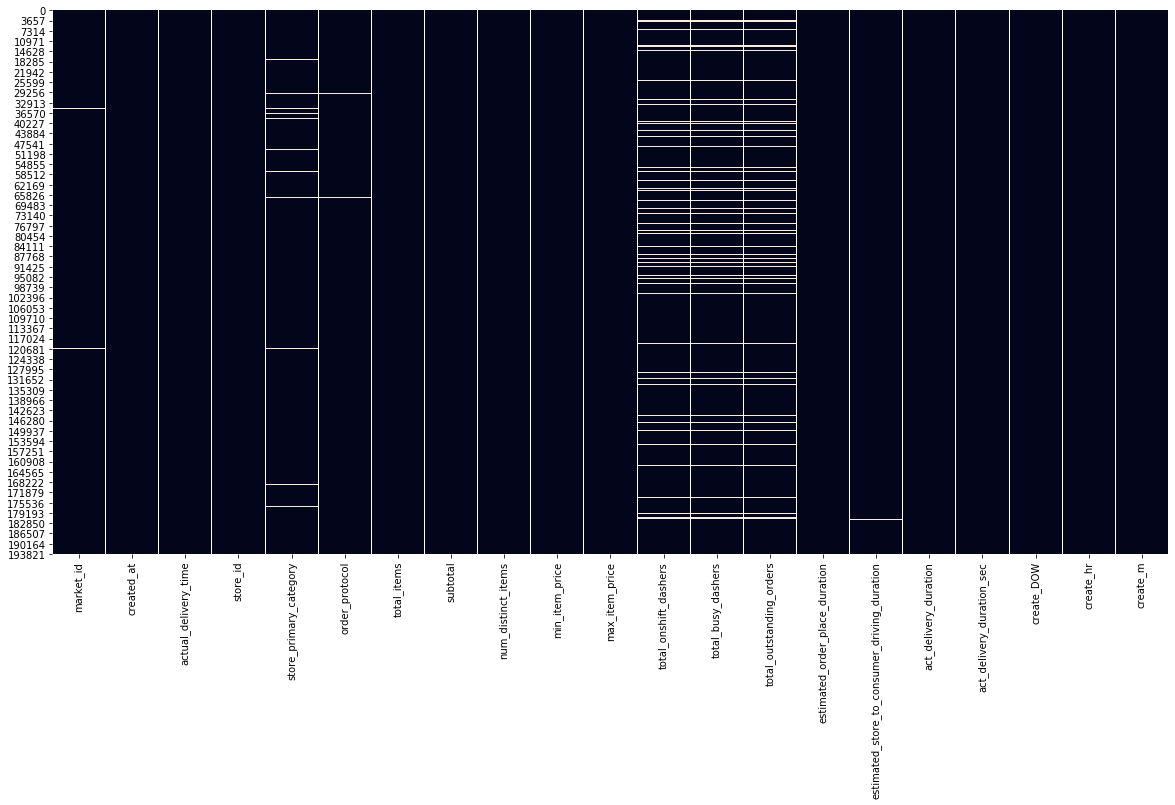

In [16]:
#show missing values with white color
plt.figure(figsize=(20, 10)) 
sns.heatmap(df_train.isnull(), cbar=False)

total_busy_dashers and total_outstanding_orders are subset from total_onshift_dashers.
They have same missing value in the dataset. Not sure if it's system error. 


Missing value processing
- market_id: will drop them
- actual_delivery_time: not sure if the delivery has been cancel, will drop them
- store_primary_category: will ignore
- order_protocol: will ignore
- total_onshift_dashers: system error? may fill up with the avg total_onshift_dashers at same market id and created hour.
- total_busy_dashers: system error?
- total_outstanding_orders: system error?

In [17]:
#drop nan from actual_delivery_time
df_train = df_train[df_train['actual_delivery_time'].notna()]

In [18]:
#drop nan from market id
df_train = df_train[df_train['market_id'].notna()]
df_test = df_test[df_test['market_id'].notna()]

In [19]:
df_train[df_train['total_onshift_dashers'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,225,...,NaN,NaN,NaN,251,671.0,00:30:55,1855.0,4,1,2
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,185,...,NaN,NaN,NaN,251,893.0,01:09:50,4190.0,5,2,2
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,650,...,NaN,NaN,NaN,251,479.0,00:57:02,3422.0,5,21,1
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,225,...,NaN,NaN,NaN,251,1104.0,02:03:12,7392.0,6,3,2
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,185,...,NaN,NaN,NaN,251,584.0,00:56:08,3368.0,4,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,indian,2.0,3,1792,3,163,...,NaN,NaN,NaN,251,725.0,00:37:44,2264.0,1,19,2
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,indian,2.0,8,2923,5,50,...,NaN,NaN,NaN,251,683.0,00:52:38,3158.0,4,3,2
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,indian,2.0,3,3297,3,799,...,NaN,NaN,NaN,251,725.0,00:45:21,2721.0,4,3,1
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,indian,2.0,4,2776,4,179,...,NaN,NaN,NaN,251,820.0,00:48:38,2918.0,5,3,1


In [20]:
# fill up nan with same market and same created hour
df_train["total_onshift_dashers"] =df_train.groupby(["market_id",'create_hr'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))
df_train["total_busy_dashers"] =df_train.groupby(["market_id",'create_hr'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))
df_train["total_outstanding_orders"] =df_train.groupby(["market_id",'create_hr'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.mean()))

In [21]:
# fill up nan with same market and same created hour
df_test["total_onshift_dashers"] =df_test.groupby(["market_id",'create_hr'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))
df_test["total_busy_dashers"] =df_test.groupby(["market_id",'create_hr'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))
df_test["total_outstanding_orders"] =df_test.groupby(["market_id",'create_hr'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.mean()))

In [22]:
# after replacing value still train data still have 2 nan, test data have 4 nan, will drop them
#drop nan from total_onshift_dashers
df_train = df_train[df_train['total_onshift_dashers'].notna()]
df_test = df_test[df_test['total_onshift_dashers'].notna()]

## Univariate

### Categorical

2.0    55055
4.0    47597
1.0    38037
3.0    23296
5.0    17999
6.0    14448
Name: market_id, dtype: int64
------------------
american             19345
pizza                17274
mexican              17050
burger               10933
sandwich             10037
                     ...  
lebanese                 9
belgian                  2
indonesian               2
alcohol-plus-food        1
chocolate                1
Name: store_primary_category, Length: 74, dtype: int64
------------------
5    34378
6    33459
4    27739
0    27264
3    25562
2    24128
1    23902
Name: create_DOW, dtype: int64
------------------
2     36753
1     28030
3     26959
20    15491
4     15191
19    13467
0     12608
21    11414
22     8783
23     8125
5      7058
18     5071
17     3388
16     2102
6      1406
15      535
14       40
7         9
8         2
Name: create_hr, dtype: int64
------------------
2     128279
1      68152
10         1
Name: create_m, dtype: int64
------------------


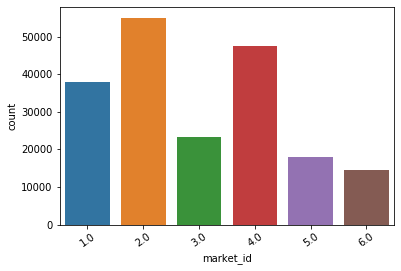

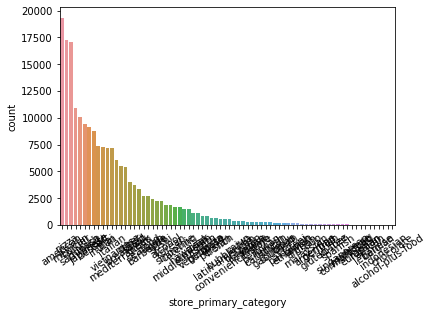

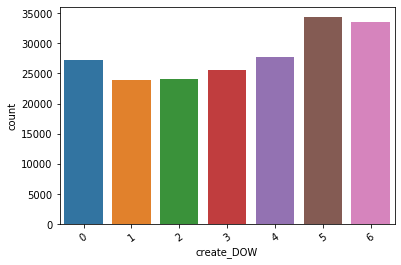

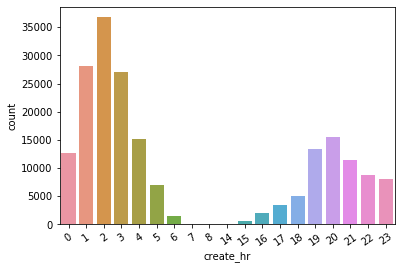

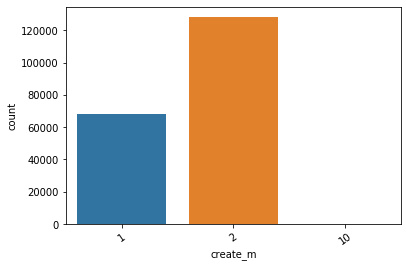

In [23]:
categorical_columns = ['market_id','store_primary_category','create_DOW','create_hr','create_m']
for i,c in enumerate(categorical_columns):
    df_cat = df_train[c].value_counts().to_frame().reset_index()
    df_cat.columns = [c,"count"]
    plt.figure(i)
    sns.barplot(df_cat[c],df_cat["count"])
    plt.xticks(rotation=35)
    #plt.figure(figsize = (10,8))
    print(df_train[c].value_counts())
    print("------------------")

Findings:
- Top demand of restaurant categories: Ameriacan, pizza, mexian, burger and sandwich. They are mostly light food and easily to get.
- Market 2 & 4 has the most delivery demand.
- Most of demands are from the weekend
- There are three obvious patterns in demand by the created hour: 0am - 5am, 6am-3pm, 4pm-11pm.
- Faburary has more demand than January.


### Numerical 

In [24]:
df_train.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m
count,196432.000000,196432.000000,195924.000000,196432.000000,196432.000000,196432.000000,196432.000000,196432.000000,196432.000000,196432.000000,196432.000000,196432.000000,195907.000000,196432,1.964320e+05,196432.000000,196432.000000,196432.000000
mean,2.978669,3530.469852,2.882189,3.196246,2682.375280,2.670787,686.319362,1159.708393,44.699045,41.654869,57.978908,308.574362,545.295896,0 days 00:48:28.403671,2.908404e+03,3.219659,8.468890,1.653091
std,1.524856,2053.188555,1.503725,2.667779,1823.160343,1.630414,522.346564,558.605773,33.638941,31.290037,51.372007,90.148796,219.343564,0 days 05:21:17.791387,1.927779e+04,2.045668,8.659268,0.476373
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,0 days 00:01:41,1.010000e+02,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,18.000000,16.000000,18.000000,251.000000,382.000000,0 days 00:35:04,2.104000e+03,1.000000,2.000000,1.000000
50%,3.000000,3591.500000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,42.000000,251.000000,544.000000,0 days 00:44:20,2.660000e+03,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.362832,61.000000,86.000000,446.000000,702.000000,0 days 00:56:21,3.381000e+03,5.000000,19.000000,2.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,98 days 13:47:39,8.516859e+06,6.000000,23.000000,10.000000


In [25]:
df_test.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id,create_DOW,create_hr,create_m
count,54524.000000,54524.000000,54380.000000,54524.000000,54524.000000,54524.000000,54524.000000,54524.000000,54524.000000,54524.000000,54524.000000,54524.000000,54513.000000,54524.000000,54524.000000,54524.000000,54524.0
mean,3.031142,3489.495782,2.885252,3.227459,2715.887646,2.691805,683.702241,1166.637334,48.918854,43.384638,62.348444,308.085467,547.789261,126125.120864,3.225442,8.533050,2.0
std,1.531451,2050.372898,1.512059,2.555278,1897.504650,1.650346,537.698282,573.944631,36.552590,33.076423,54.738270,88.926441,220.473384,72694.633707,2.069261,8.717707,0.0
min,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,-63.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,0.000000,20.000000,0.000000,0.000000,2.0
25%,2.000000,1661.000000,1.000000,2.000000,1420.000000,2.000000,299.000000,819.000000,20.000000,17.000000,20.000000,251.000000,385.000000,62923.500000,1.000000,2.000000,2.0
50%,3.000000,3518.000000,3.000000,3.000000,2220.000000,2.000000,595.000000,1095.000000,40.400000,36.000000,46.363636,251.000000,544.000000,126215.000000,3.000000,3.000000,2.0
75%,4.000000,5248.000000,4.000000,4.000000,3415.000000,3.000000,929.000000,1399.000000,69.555556,63.000000,89.638889,446.000000,703.000000,188923.750000,5.000000,19.000000,2.0
max,6.000000,6986.000000,7.000000,81.000000,29925.000000,19.000000,25040.000000,25142.000000,175.000000,169.000000,292.000000,1095.000000,1550.000000,252031.000000,6.000000,23.000000,2.0


In [26]:
#not sure what happened to those negative value, will make all the negative value to 0
df_train.loc[df_train.total_onshift_dashers < 0, 'total_onshift_dashers'] = 0
df_train.loc[df_train.total_busy_dashers < 0, 'total_busy_dashers'] = 0
df_train.loc[df_train.total_outstanding_orders < 0, 'total_outstanding_orders'] = 0
df_train.loc[df_train.min_item_price < 0, 'min_item_price'] = 0

df_test.loc[df_test.total_onshift_dashers < 0, 'total_onshift_dashers'] = 0
df_test.loc[df_test.total_busy_dashers < 0, 'total_busy_dashers'] = 0
df_test.loc[df_test.total_outstanding_orders < 0, 'total_outstanding_orders'] = 0
df_test.loc[df_test.min_item_price < 0, 'min_item_price'] = 0

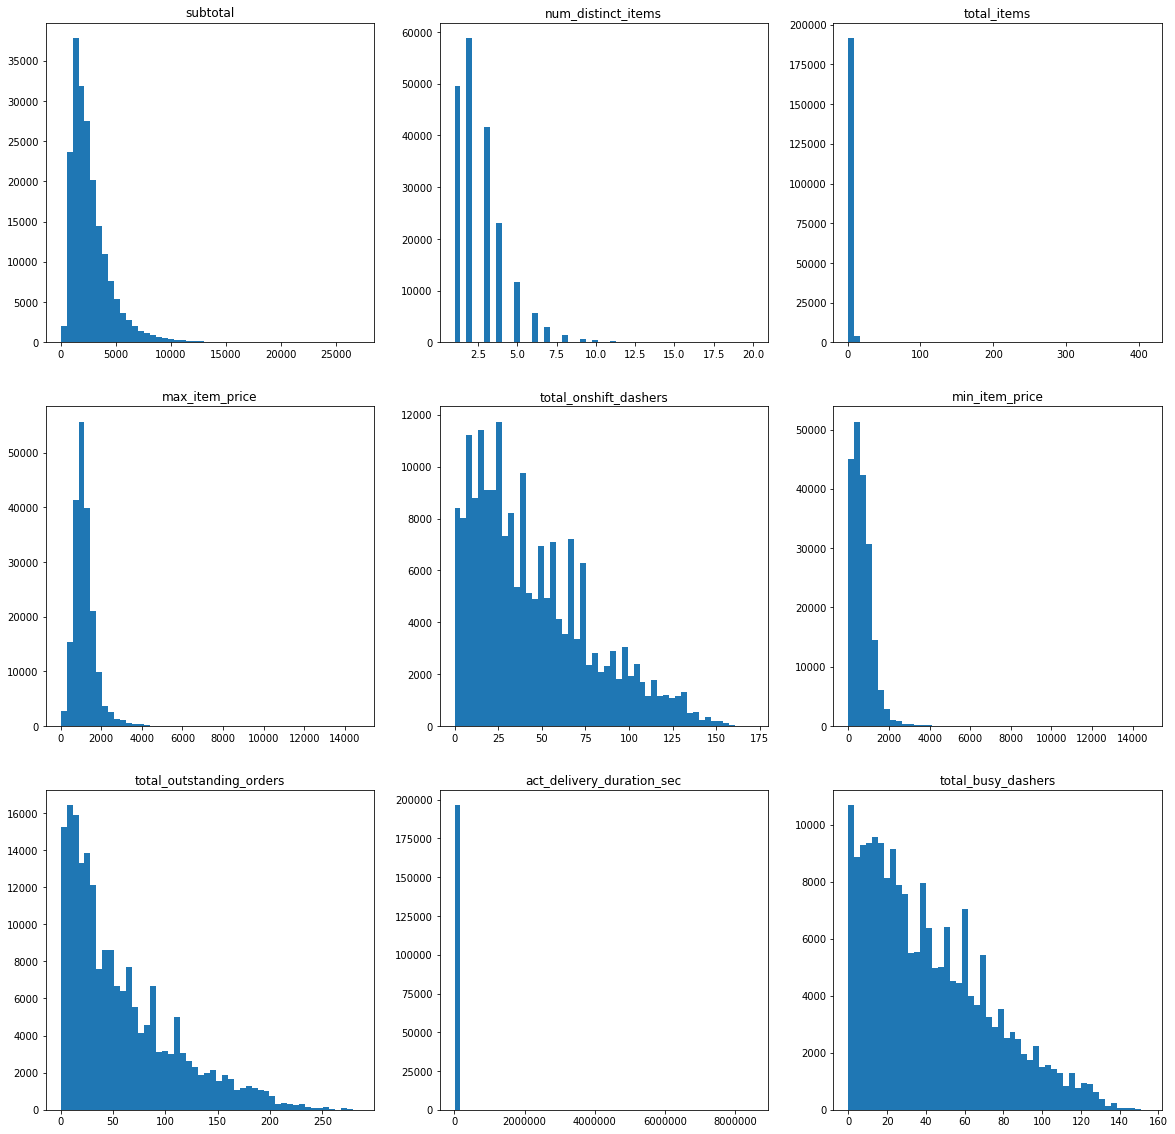

In [27]:
#check Numerical variables distribution
Numerical_column = ['total_items',  'subtotal', 'num_distinct_items', 'min_item_price','max_item_price','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','act_delivery_duration_sec']
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i,n in enumerate(Numerical_column):
    axes[i//3][(i%3)-1].hist(df_train[n],bins=50)
    axes[i//3][(i%3)-1].set_title(n)

- total item mostly smaller than 20 per delivery.
- num of distinct item mostly smaller than 7
- 

### Outlier Processing

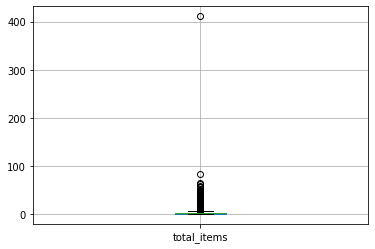

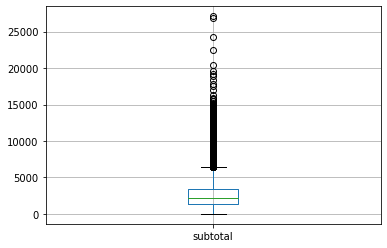

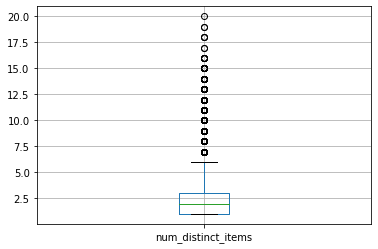

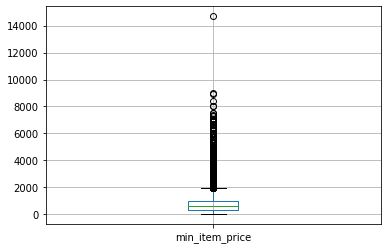

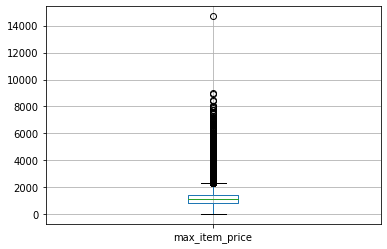

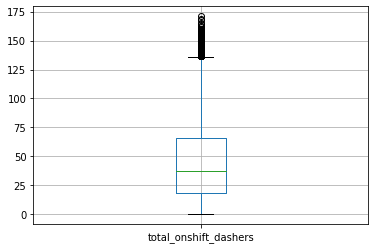

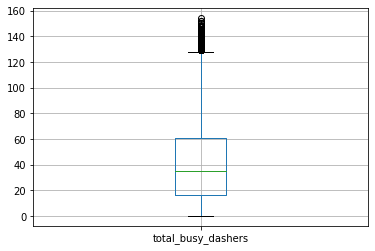

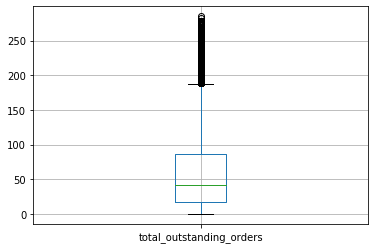

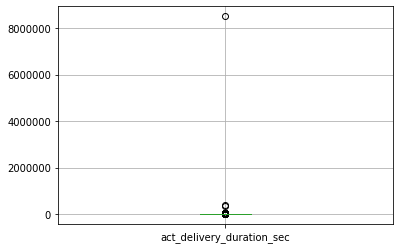

In [28]:
for i in (Numerical_column):
    boxplt = df_train.boxplot(column=[i])
    plt.show()

Finding:
- total items & actual delivery duration has outliers, should dig out more

In [29]:
#drop 411 outlier from total items
df_train.drop(df_train.loc[df_train['total_items']==411].index, inplace=True)

In [30]:
df_train[df_train['act_delivery_duration_sec'] == 8516859]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,...,13.780541,13.176298,14.544257,446,412.0,98 days 13:47:39,8516859.0,6,5,10


In [31]:
#drop outlier value of delivery time
df_train = df_train.drop([2690])

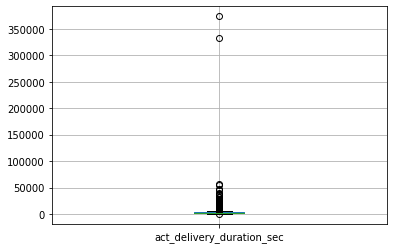

In [32]:
boxplt = df_train.boxplot(column=['act_delivery_duration_sec'])
boxplt

Finding: still found two extreme values from delivery time, will drop them

In [33]:
df_train['act_delivery_duration_sec'].max()

373879.0

In [34]:
df_train[df_train['act_delivery_duration_sec'] == 373879.0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m
185550,4.0,2015-01-28 08:34:06,2015-02-01 16:25:25,6503,dessert,5.0,3,1520,3,220,...,0.0,0.0,0.0,251,476.0,4 days 07:51:19,373879.0,2,8,1


In [35]:
#drop delivery outlier value
df_train = df_train.drop([185550])

In [36]:
df_train['act_delivery_duration_sec'].max()

332482.0

In [37]:
df_train[df_train['act_delivery_duration_sec'] == 332482.0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m
27189,1.0,2015-02-16 02:24:09,2015-02-19 22:45:31,4338,indian,3.0,4,4980,4,995,...,72.0,68.0,104.0,251,767.0,3 days 20:21:22,332482.0,0,2,2


In [38]:
df_train = df_train.drop([27189])

## Multivariate

In [39]:
df_train.corr()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m
market_id,1.000000,0.017295,-0.021904,-0.006780,-0.016213,0.002551,-0.000116,-0.004888,0.063241,0.056827,0.061566,-0.053268,0.006580,-0.046690,-0.002511,-0.013885,0.040419
store_id,0.017295,1.000000,0.019508,-0.008240,-0.013458,-0.012862,-0.009290,-0.018712,-0.022409,-0.022537,-0.019915,0.017378,0.002002,-0.010085,-0.000691,0.010129,0.003757
order_protocol,-0.021904,0.019508,1.000000,0.008925,-0.053464,-0.023139,-0.045473,-0.090879,0.138758,0.143320,0.128811,-0.678268,-0.008495,-0.065974,-0.000875,0.015711,0.005090
total_items,-0.006780,-0.008240,0.008925,1.000000,0.594001,0.812415,-0.417499,-0.060860,0.032456,0.029017,0.034902,-0.024902,0.004873,0.118194,0.023108,-0.070270,-0.005371
subtotal,-0.016213,-0.013458,-0.053464,0.594001,1.000000,0.680947,0.037221,0.505500,0.129104,0.123794,0.127914,0.038744,0.034795,0.204313,0.032353,-0.184640,-0.006220
num_distinct_items,0.002551,-0.012862,-0.023139,0.812415,0.680947,1.000000,-0.448677,0.041683,0.064244,0.058976,0.065721,0.003336,0.022710,0.147692,0.029361,-0.114453,-0.002014
min_item_price,-0.000116,-0.009290,-0.045473,-0.417499,0.037221,-0.448677,1.000000,0.545890,0.043310,0.044798,0.042043,0.052936,0.003250,0.014973,-0.000038,-0.050688,0.002009
max_item_price,-0.004888,-0.018712,-0.090879,-0.060860,0.505500,0.041683,0.545890,1.000000,0.133468,0.131373,0.130833,0.084972,0.026713,0.126229,0.029881,-0.186477,0.004768
total_onshift_dashers,0.063241,-0.022409,0.138758,0.032456,0.129104,0.064244,0.043310,0.133468,1.000000,0.945448,0.937915,-0.176927,0.041857,0.071884,0.092499,-0.382443,0.025327
total_busy_dashers,0.056827,-0.022537,0.143320,0.029017,0.123794,0.058976,0.044798,0.131373,0.945448,1.000000,0.934771,-0.183229,0.040390,0.089290,0.077100,-0.358903,-0.042352


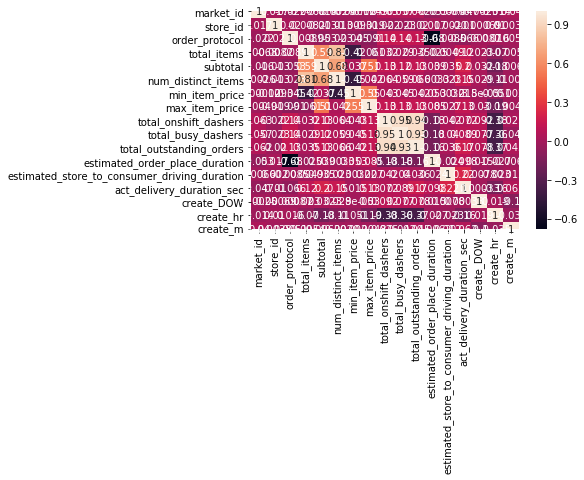

In [40]:
#covariance matrix plot
corrMatrix = df_train.corr()
corr = sns.heatmap(corrMatrix, annot=True) 


Finding:
- order_protocol & estimated_order_place_duration has high correlation: -0.68
- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash, which imply the estimate time has high correlation with order_protocol.


### Recategorize variables

In [41]:
df_train['total_items_cat'] = np.where(df_train['total_items'] > 5 ,'>5','<=5')

### Delivery Time Duration

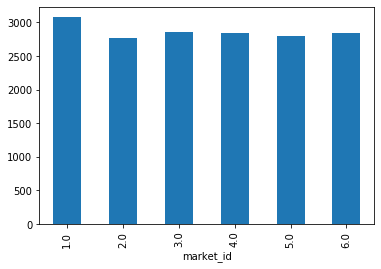

In [42]:
df_train.groupby(['market_id'])['act_delivery_duration_sec'].mean().plot.bar()

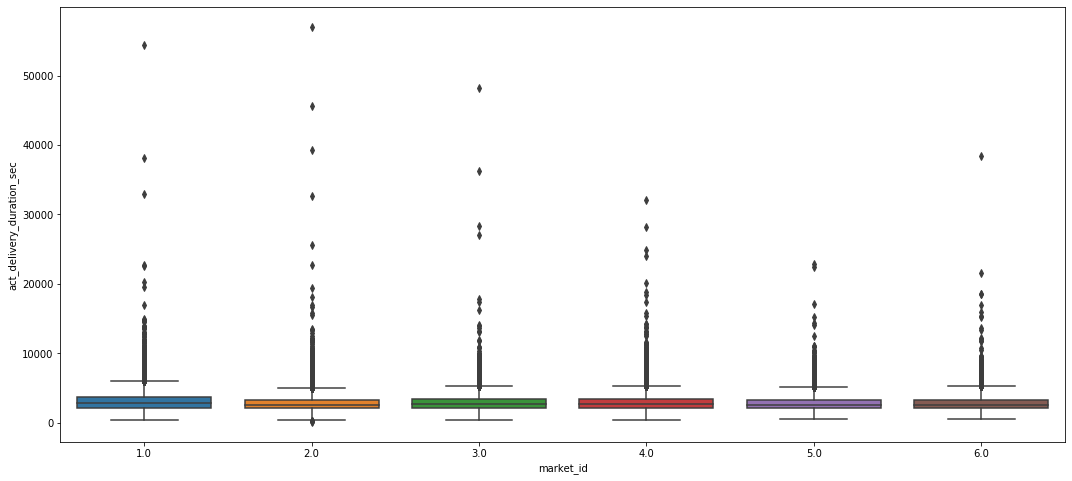

In [43]:
plt.figure(figsize=(18,8))
sns.boxplot(data=df_train,x='market_id',y='act_delivery_duration_sec')

- Delivery time are not variety by market_id
- we can assume that those cities/regions are nearby.

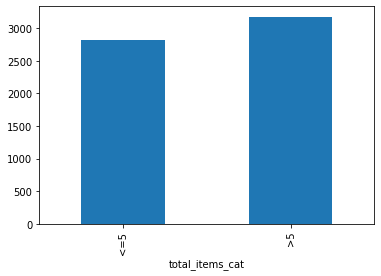

In [44]:
df_train.groupby(['total_items_cat'])['act_delivery_duration_sec'].mean().plot.bar()

Delivery time varies the total items category.

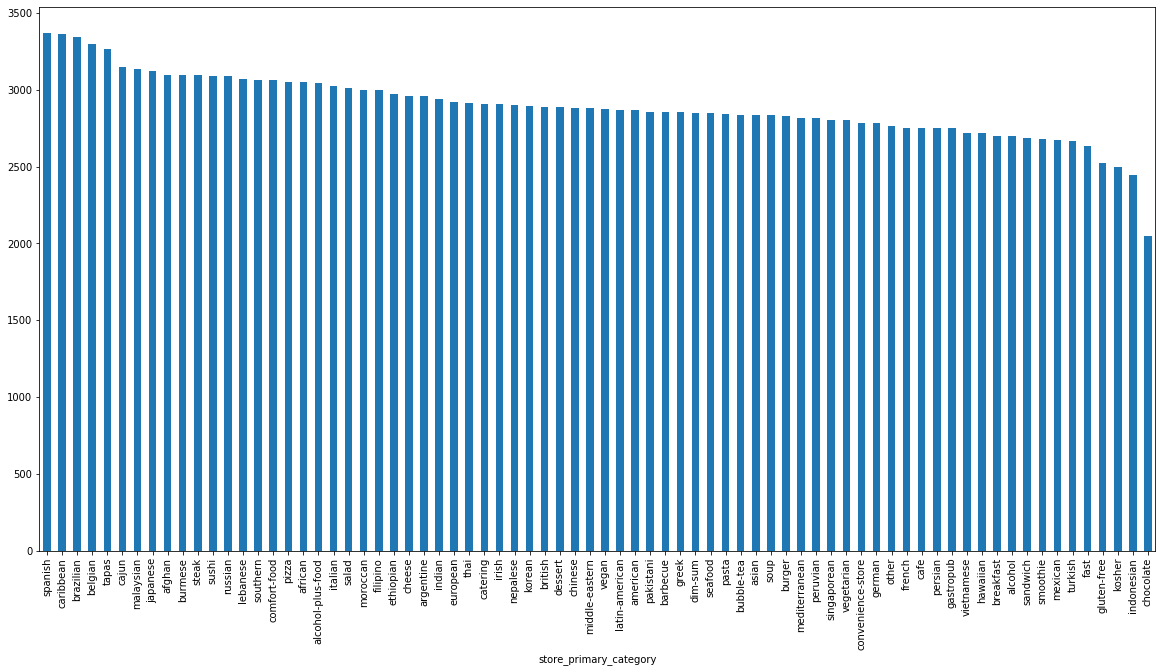

In [45]:
df_train.groupby(['store_primary_category'])['act_delivery_duration_sec'].mean().sort_values(ascending = False).plot.bar(figsize=(20,10))

Finding: 
- Avg delivery time will be different by category of store, those extreme categories don't have that much demand. 

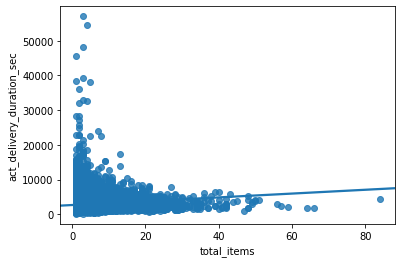

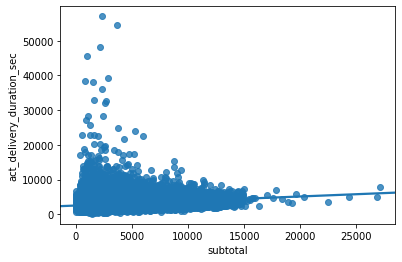

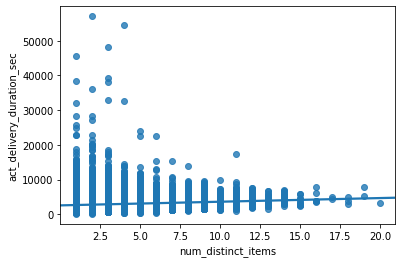

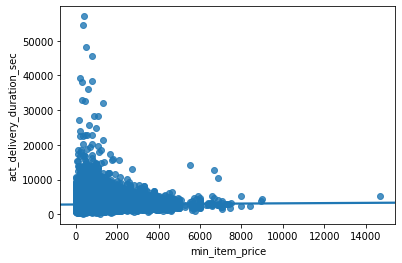

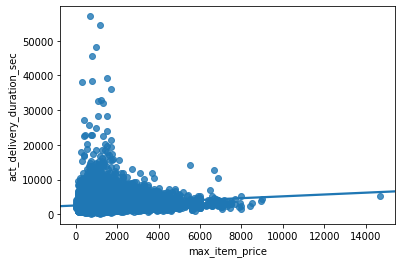

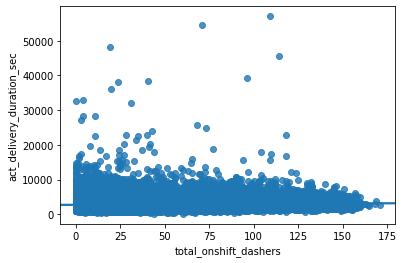

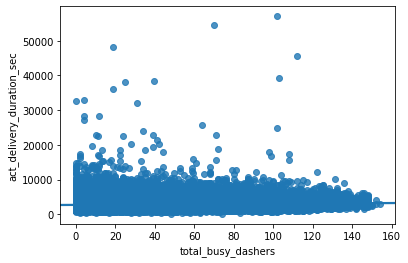

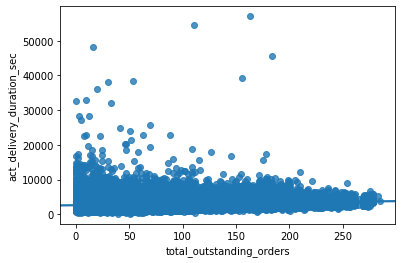

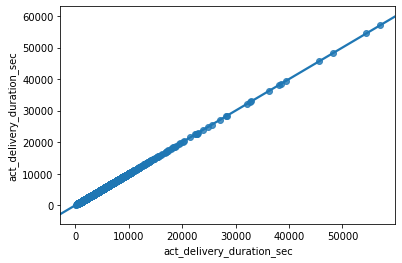

In [46]:
for i in (Numerical_column):
    regplt = sns.regplot(x=i,y="act_delivery_duration_sec", data=df_train)
    plt.show()

Findings:
- The more totals items delivered and higher subtotal, the deliver time takes longer
- The higher number of distinct items order and price take slightly longer time as expectation.

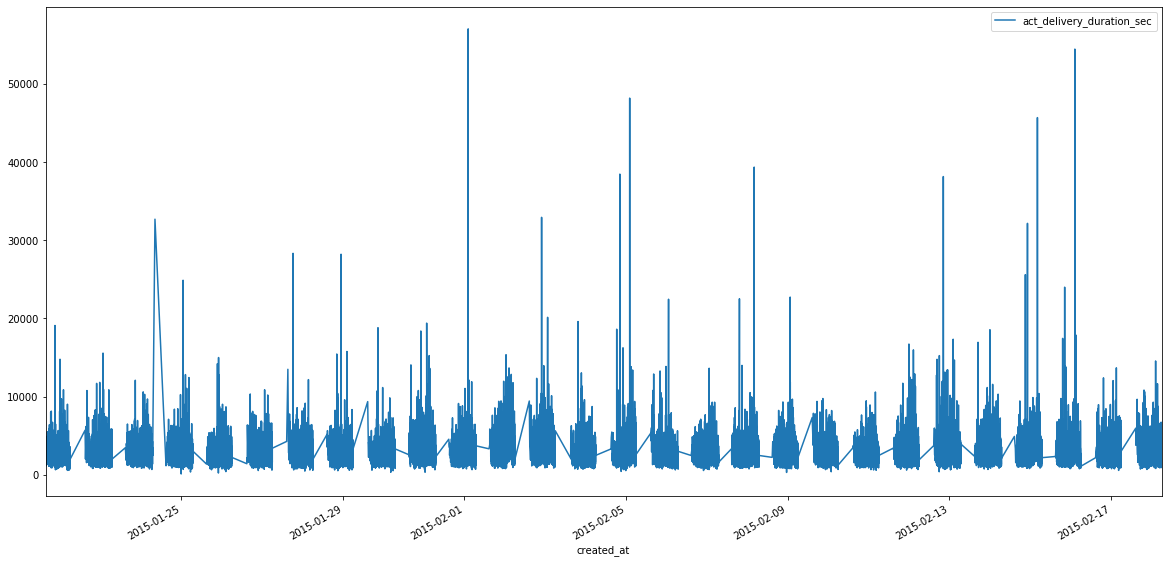

In [47]:
df_train.groupby([df_train["created_at"]]).mean()[['act_delivery_duration_sec']].plot(legend=True, figsize=(20,10))

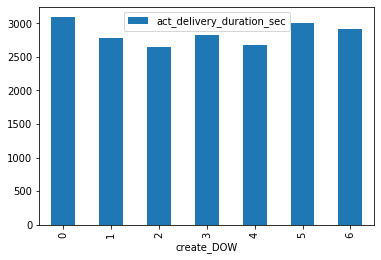

In [48]:
#created_at day of week/ avg actual delivery time
#0 Monday 6 Sunday
df_train.groupby(["create_DOW"]).mean()[['act_delivery_duration_sec']].plot.bar(legend=True)

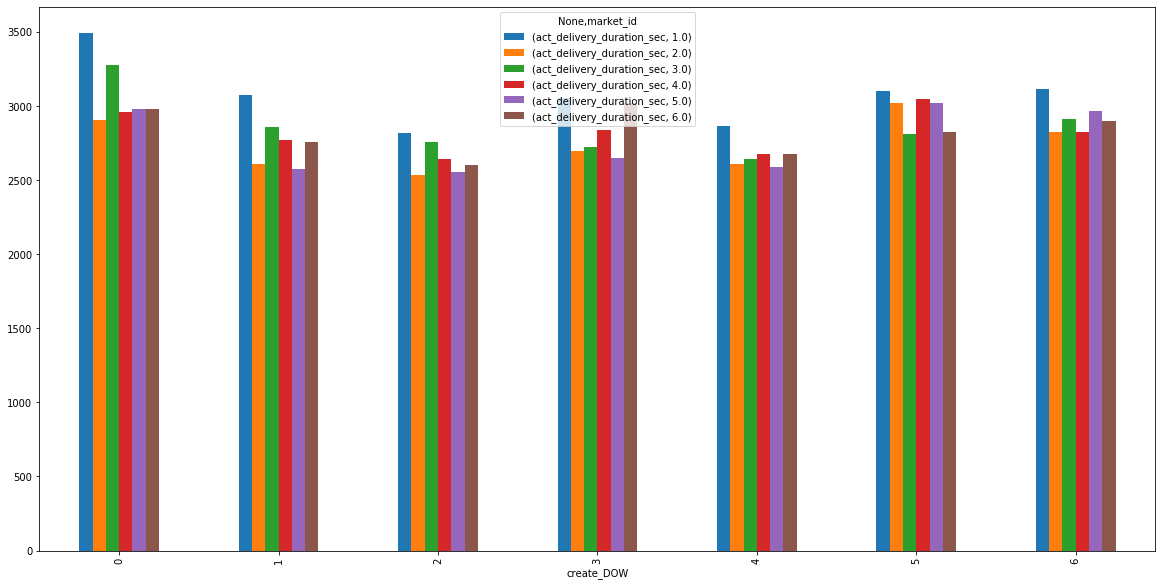

In [49]:
df_train.groupby(["create_DOW",'market_id']).mean()[['act_delivery_duration_sec']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

Finding:
- Monday has the highest average delivery time. the following is Saturday & Sunday (Weekend)
- Market 1 has longer delivery time than other markets

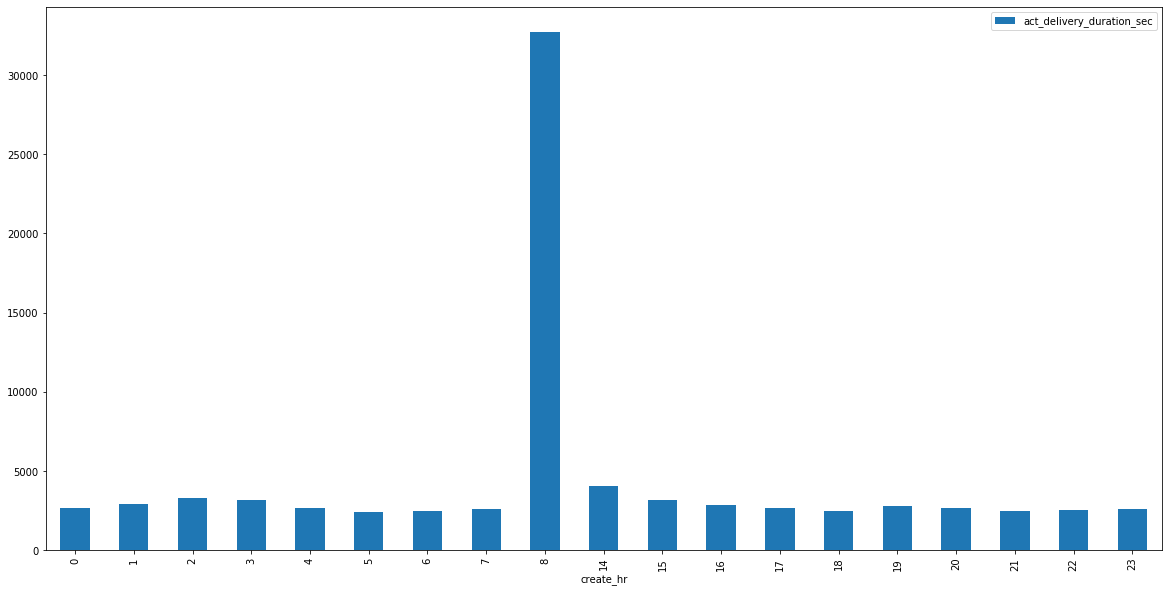

In [50]:
#created_at hour in a day/ avg actual delivery time
df_train.groupby(["create_hr"]).mean()[['act_delivery_duration_sec']].plot.bar(legend=True, figsize=(20,10))

In [51]:
df_train.groupby(by = "create_hr").mean()['act_delivery_duration_sec']

create_hr
0      2648.049179
1      2936.287478
2      3290.281264
3      3154.007011
4      2676.408400
5      2402.865807
6      2446.429587
7      2601.222222
8     32690.000000
14     4057.600000
15     3176.469159
16     2861.094196
17     2658.038666
18     2455.283770
19     2770.472414
20     2656.173456
21     2465.794901
22     2527.252989
23     2608.697723
Name: act_delivery_duration_sec, dtype: float64

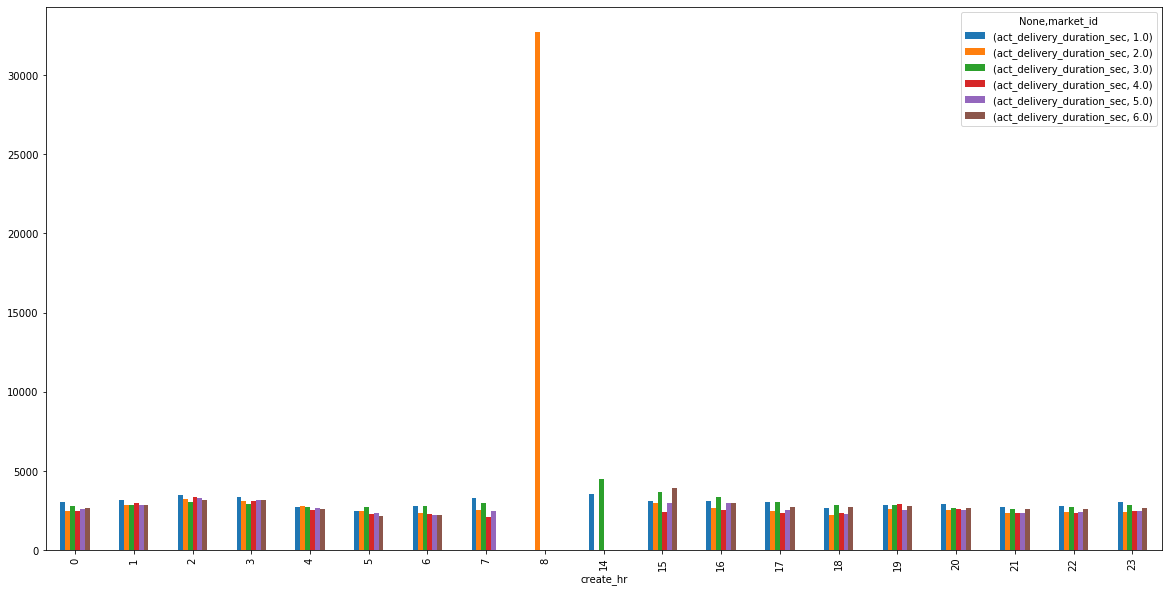

In [52]:
df_train.groupby(["create_hr",'market_id']).mean()[['act_delivery_duration_sec']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

In [53]:
df_train[(df_train['create_hr'] == 8) & (df_train['market_id'] == 2)]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,act_delivery_duration,act_delivery_duration_sec,create_DOW,create_hr,create_m,total_items_cat
63505,2.0,2015-01-24 08:19:17,2015-01-24 17:24:07,441,american,5.0,4,2740,4,425,...,0.0,0.0,251,730.0,09:04:50,32690.0,5,8,1,<=5


In [54]:
df_train = df_train.drop([63505])

8am with market id2 has suspected trend, which take 9 hrs for delivery, and there is only one data. I'll view it as outlier and drop it. 


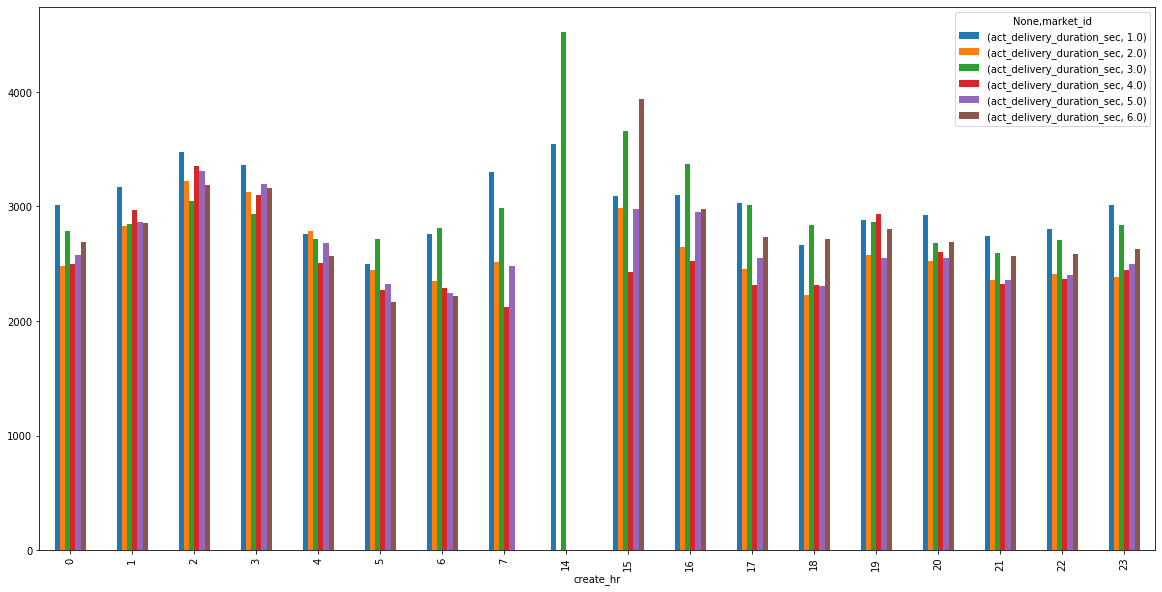

In [55]:
#check the data again
#created_at hour in a day/ avg actual delivery time
df_train.groupby(["create_hr",'market_id']).mean()[['act_delivery_duration_sec']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

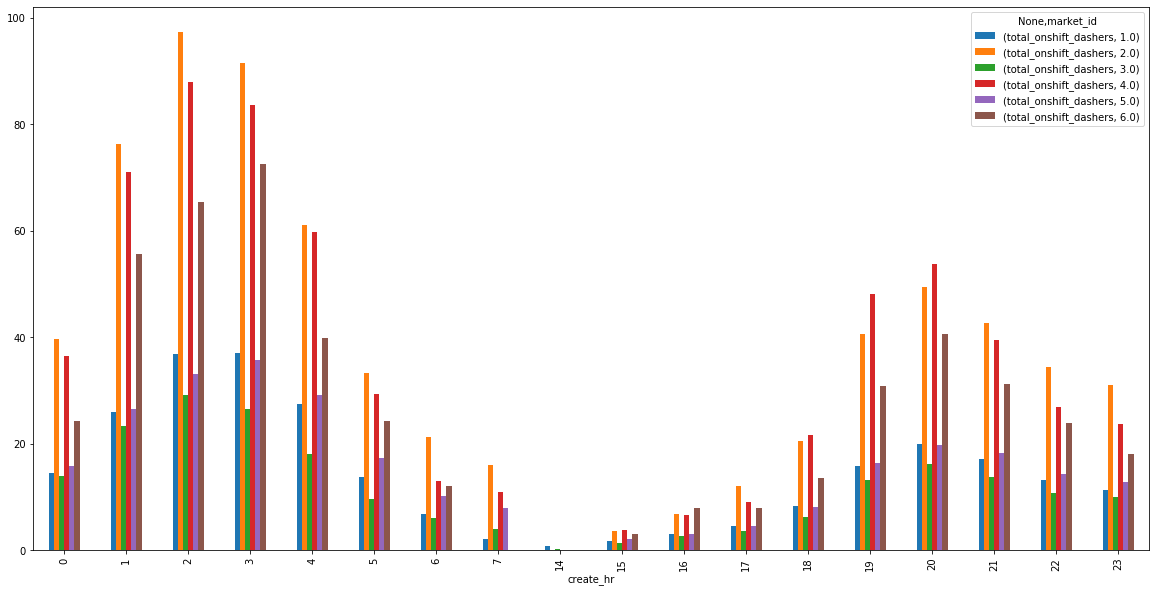

In [56]:
df_train.groupby(["create_hr",'market_id']).mean()[['total_onshift_dashers']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

Findings:
Number of available dashers who are within 10 miles of the store at the time of order creation is vaiety by hour in a day. 
- All the markets have similar pattern of the number of available dashers.
- From 8am - 3pm, there are less dashers working in this peirod.
- Market 2 & 4 has more avaliable dashers, suggesting they might be a bigger city/region compared to other markets.
- Market 1 & 3 take longer delivery time than other markets.
- The number of available dashers will affect the time delivery in some markets.


## Machine Learning Models

In [57]:
def mae(actual,forecast):
    result = 0 
    for a,f in zip(actual,forecast):
        result += abs(a-f)
    return result/len(forecast)

def mape(actual, forecast): 
    result = 0 
    for a,f in zip(actual,forecast):
            result += abs(a-f)/a
    return result/len(forecast)
    
def rmse(actual, forecast): 
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return rmse

In [58]:
#error display function
def run_error_result(actual,forecast,name):
    def mae(actual,forecast):
        result = 0 
        for a,f in zip(actual,forecast):
            result += abs(a-f)
        return result/len(forecast)

    def mape(actual, forecast): 
        result = 0 
        for a,f in zip(actual,forecast):
                result += abs(a-f)/a
        return result/len(forecast)
    
    def rmse(actual, forecast): 
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        return rmse
    
    return pd.DataFrame({'MAE':[mae(actual, forecast)],'MAPE': [mape(actual,forecast)],'RMSE': [rmse(actual,forecast)]},index=pd.Series([name]))

In [59]:
df_train['total_items_cat']=df_train['total_items_cat'].astype('category')
df_train['total_items_cat_c']=df_train['total_items_cat'].cat.codes

### Linear Regression

In [60]:
def delivery_time_reg(data, groupby):
    y=data['act_delivery_duration_sec'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=109)  

    #fit LR model
    model = LinearRegression().fit(X_train, y_train)    
    print(model.coef_)
    
    # with statsmodels
    x_train = sm.add_constant(X_train) # adding a constant
    x_test = sm.add_constant(X_test) # adding a constant
    
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())
    ## predict test set  (out-sample)
    out_forecast = model.predict(X_test)
    ## predict train set  (in-sample)
    in_forecast = model.predict(X_train)
    
    print(run_error_result(y_test, out_forecast,'Out-sample'))
    print(run_error_result(y_train, in_forecast,'In-sample'))

In [61]:
delivery_time_reg(df_train, ['market_id','store_id','create_hr','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','num_distinct_items','min_item_price','max_item_price','total_items_cat_c','subtotal'])

[-3.73389106e+01 -4.38997249e-03 -1.44620444e+01 -2.27358405e+01
 -8.48243183e+00  2.13472056e+01  2.56514379e+01  1.78256721e-02
  5.58017884e-02 -9.79827193e+00  9.00488846e-02]
                                    OLS Regression Results                                    
Dep. Variable:     act_delivery_duration_sec   R-squared (uncentered):                   0.848
Model:                                   OLS   Adj. R-squared (uncentered):              0.848
Method:                        Least Squares   F-statistic:                          5.964e+04
Date:                       Tue, 17 Nov 2020   Prob (F-statistic):                        0.00
Time:                               14:47:18   Log-Likelihood:                     -1.0031e+06
No. Observations:                     117856   AIC:                                  2.006e+06
Df Residuals:                         117845   BIC:                                  2.006e+06
Df Model:                                 11                

The variables including in the LR models are significant. They will be also considered in the following models.

### KNN Model

In [62]:
#prepare data for knn model 
def delivery_time_knn(data, groupby, k):
    y=data['act_delivery_duration_sec'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) 
    
    #KNN fit
    classifier = KNeighborsClassifier(n_neighbors=k)  
    knn = classifier.fit(X_train, y_train)

    ## predict test set  (out-sample)
    out_forecast = knn.predict(X_test)
    ## predict train set  (in-sample)
    in_forecast = knn.predict(X_train)
    print(run_error_result(y_test, out_forecast,'Out-sample'))
    print(run_error_result(y_train, in_forecast,'In-sample'))

In [63]:
#prepare data for knn model 
def delivery_time_knn_error(data, groupby, k):
    y=data['act_delivery_duration_sec'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test) 
    
    #KNN fit
    classifier = KNeighborsClassifier(n_neighbors=k)  
    knn = classifier.fit(X_train_s, y_train)

    ## predict test set  (out-sample)
    X_test['pred_delivery_time'] = knn.predict(X_test_s)
    ## predict train set  (in-sample)
    X_train['pred_delivery_time'] = knn.predict(X_train_s)
    
    a = pd.DataFrame(y_test)
    a.columns = ['actual_delivery_time']
    b = pd.DataFrame(y_train)
    b.columns = ['actual_delivery_time']
    test_result = X_test.join(a)
    train_result = X_train.join(b)
    
    #create hour list
    create_hr_bin = ['0am-5am', '6am-3pm', '4pm-23pm']
    df = pd.DataFrame(columns=['create_hr_bin','out mae','out mape','out rmse','in mae','in mape','in rmse'])
    test_result['create_hr_bin'] = pd.cut(test_result['create_hr'],[0,5,15,23],labels=create_hr_bin)
    train_result['create_hr_bin'] = pd.cut(train_result['create_hr'],[0,5,15,23],labels=create_hr_bin)
    for i in create_hr_bin:
        testing = test_result[test_result['create_hr_bin'] == i]
        training = train_result[train_result['create_hr_bin'] == i]
        df = df.append({'create_hr_bin':i,'out mae': mae(testing['actual_delivery_time'], testing['pred_delivery_time']),'out mape':mape(testing['actual_delivery_time'], testing['pred_delivery_time'])
                        ,'out rmse':rmse(testing['actual_delivery_time'], testing['pred_delivery_time']),'in mae': mae(training['actual_delivery_time'], training['pred_delivery_time']),
                        'in mape':mape(training['actual_delivery_time'], training['pred_delivery_time']),'in rmse':rmse(training['actual_delivery_time'], training['pred_delivery_time'])},ignore_index=True)
    return df


In [64]:
delivery_time_knn(df_train, ['market_id','store_id','create_hr','total_items','total_onshift_dashers'],2)

                   MAE      MAPE         RMSE
Out-sample  953.700249  0.318977  1390.993909
                  MAE      MAPE         RMSE
In-sample  525.812834  0.140621  1056.619484


In [65]:
delivery_time_knn(df_train, ['market_id','store_id','create_hr','total_onshift_dashers'],2)

                   MAE      MAPE         RMSE
Out-sample  945.573809  0.316681  1378.854832
                  MAE      MAPE         RMSE
In-sample  539.553652  0.147835  1058.848501


In [66]:
delivery_time_knn(df_train, ['market_id','create_hr','total_onshift_dashers','total_busy_dashers','total_outstanding_orders'],2)

                   MAE      MAPE         RMSE
Out-sample  888.580275  0.297621  1306.168603
                  MAE      MAPE         RMSE
In-sample  649.064765  0.196538  1105.729984


In [67]:
#check error distrubution
delivery_time_knn_error(df_train, ['market_id','create_hr','total_onshift_dashers','total_busy_dashers','total_outstanding_orders'],2)

,create_hr_bin,out mae,out mape,out rmse,in mae,in mape,in rmse
0,0am-5am,905.058449,0.285271,1319.557873,680.527512,0.198309,1123.221476
1,6am-3pm,973.691318,0.333212,1385.092232,641.486842,0.193329,1155.832588
2,4pm-23pm,862.581451,0.314055,1305.514450,604.365645,0.193799,1079.047482


- KNN is more sensitive with variables seletion. optimal k=2 is pretty small.
- Error is pretty higher in the model

### Random Forest 

In [68]:
#prepare data for Tree model 
def delivery_time_rf(data, groupby, estimators):
    y=data['act_delivery_duration_sec'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

    # random forest fit
    rf = RandomForestRegressor(n_estimators = estimators,min_samples_split=8,max_features =4)
    rf.fit(X_train, y_train)

    ## predict test set  (out-sample)
    out_forecast = rf.predict(X_test)
    ## predict train set  (in-sample)
    in_forecast = rf.predict(X_train)
    
    print(run_error_result(y_test, out_forecast,'Out-sample'))
    print(run_error_result(y_train, in_forecast,'In-sample'))

In [69]:
#prepare data for Tree model 
def delivery_time_rf_error(data, groupby,estimators):
    y=data['act_delivery_duration_sec'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

    # random forest fit
    rf = RandomForestRegressor(n_estimators =estimators,min_samples_split=8,max_features =4)
    rf.fit(X_train, y_train)

    ## predict test set  (out-sample)
    X_test['pred_delivery_time'] = rf.predict(X_test)
    ## predict train set  (in-sample)
    X_train['pred_delivery_time'] = rf.predict(X_train)
    
    a = pd.DataFrame(y_test)
    a.columns = ['actual_delivery_time']
    b = pd.DataFrame(y_train)
    b.columns = ['actual_delivery_time']
    test_result = X_test.join(a)
    train_result = X_train.join(b)
    
    #create hour list
    create_hr_bin = ['0am-5am', '6am-3pm', '4pm-23pm']
    df = pd.DataFrame(columns=['create_hr_bin','out mae','out mape','out rmse','in mae','in mape','in rmse'])
    test_result['create_hr_bin'] = pd.cut(test_result['create_hr'],[0,5,15,23],labels=create_hr_bin)
    train_result['create_hr_bin'] = pd.cut(train_result['create_hr'],[0,5,15,23],labels=create_hr_bin)
    for i in create_hr_bin:
        testing = test_result[test_result['create_hr_bin'] == i]
        training = train_result[train_result['create_hr_bin'] == i]
        df = df.append({'create_hr_bin':i,'out mae': mae(testing['actual_delivery_time'], testing['pred_delivery_time']),'out mape':mape(testing['actual_delivery_time'], testing['pred_delivery_time'])
                        ,'out rmse':rmse(testing['actual_delivery_time'], testing['pred_delivery_time']),'in mae': mae(training['actual_delivery_time'], training['pred_delivery_time']),
                        'in mape':mape(training['actual_delivery_time'], training['pred_delivery_time']),'in rmse':rmse(training['actual_delivery_time'], training['pred_delivery_time'])},ignore_index=True)
    return df

In [70]:
delivery_time_rf(df_train, ['market_id','store_id','create_hr','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','total_items'],300)

                   MAE     MAPE         RMSE
Out-sample  714.476449  0.27313  1077.767903
                  MAE      MAPE        RMSE
In-sample  447.557862  0.170566  662.251605


In [71]:
#the lowest error i get so far
delivery_time_rf(df_train, ['market_id','store_id','create_hr','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','total_items','num_distinct_items','min_item_price','max_item_price'],300)

                   MAE      MAPE         RMSE
Out-sample  703.150576  0.268851  1065.781314
                  MAE      MAPE        RMSE
In-sample  410.005634  0.156622  616.472364


In [72]:
#check error distrubution
delivery_time_rf_error(df_train, ['market_id','store_id','create_hr','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','total_items','num_distinct_items','min_item_price','max_item_price'],300)

,create_hr_bin,out mae,out mape,out rmse,in mae,in mape,in rmse
0,0am-5am,719.554903,0.258089,1075.639061,418.472463,0.150031,622.595749
1,6am-3pm,777.905683,0.318720,1099.363484,448.792746,0.187200,662.077259
2,4pm-23pm,677.175830,0.282448,1074.832692,397.040380,0.165489,606.694059


## Prediction on Test Dataset

In [78]:
#will use the best model (random forest) to predict the test dataset
y=df_train['act_delivery_duration_sec'].astype('int64')
X=df_train[['market_id','store_id','create_hr','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','total_items','num_distinct_items','min_item_price','max_item_price']]
#Data partitioning into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

# random forest fit
rf = RandomForestRegressor(n_estimators = 300,min_samples_split=8,max_features =4)
rf.fit(X_train, y_train)

test = df_test[['market_id','store_id','create_hr','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','total_items','num_distinct_items','min_item_price','max_item_price']]
rf.fit(X_train, y_train)
## predict test dataset
df_test['predicted_delivery_duration'] = rf.predict(test)

In [79]:
#print out the final prediction of delivery duration
print("Predictions for deliveries: ")
print(df_test[['delivery_id','predicted_delivery_duration']])

Predictions for deliveries: 
       delivery_id  predicted_delivery_duration
0           194096                  2921.240460
1           236895                  3259.602207
2           190868                  3371.082714
3           183076                  2877.536803
4           186200                  3236.798042
...            ...                          ...
54773       174203                  2355.887162
54774       138333                  2858.265231
54775        34110                  2985.169373
54776       178028                  3163.096349
54777       132824                  3249.389744

[54524 rows x 2 columns]


In [122]:
df_test.to_csv('data_to_predict.csv')